In [404]:
import tweetdf
import geopandas
import pandas
import trips
import odm
import sampers
import matplotlib.pyplot as plt
import matplotlib as mpl
import partition
import numpy as np
region = 'national'

# Partition tweets into Samper's grid system

In this notebook we extract displacements from tweets in a region, and construct an ODM based on the grids used by Samper's model.

In [200]:
tweets = tweetdf.from_csv("./../../dbs/Sweden.csv")
tweets.shape

(1302359, 9)

1,3 Million geotagged tweets (by users with a detected home location in Sweden)

In [421]:
tweets = tweets.dropna()
tweets.shape

(1302358, 9)

## Extract displacements
Currently, we consider two consecutive stays to be a displacement if and only if the time between them is less than 12 hours.

Construct ODM without aggregation into zones (based on lat/long)

In [408]:
latlngodm = odm.from_trips(displacements)
latlngodm.head()

,latitude_o,longitude_o,latitude_d,longitude_d,count
0,-79.898133,-49.192753,59.350000,18.066667,1
1,-54.809017,-68.302105,-54.808049,-68.307551,1
2,-54.808219,-68.318154,-54.809017,-68.302105,1
3,-54.808049,-68.307551,-54.783803,-68.259351,1
4,-54.805765,-68.307080,-54.783803,-68.259351,1


In [405]:
shp = sampers.read_shp(sampers.shps[region])
shp

,zone,geometry
0,971141,"POLYGON ((659511.292 6607261.185, 659894.494 6..."
1,971151,"POLYGON ((687577.723 6620262.072, 687608.925 6..."
2,971171,"POLYGON ((702463.876 6611356.237, 703037.832 6..."
3,971201,"POLYGON ((693308.815 6582233.134, 693354.937 6..."
4,971202,"POLYGON ((734821.187 6600899.336, 738146.311 6..."
...,...,...
677,995843,"POLYGON ((759180.250 7537585.922, 757972.575 7..."
678,995844,"POLYGON ((724478.311 7537822.934, 724781.238 7..."
679,995845,"MULTIPOLYGON (((736804.562 7536988.435, 736917..."
680,995846,"MULTIPOLYGON (((659413.222 7585105.434, 656337..."


The above dataset defines the zones used by Samper's model.

Low resolution shape of sweden.

In [406]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
sweden = countries[countries.name == "Sweden"]

## ODM construction
Aggregate displacements into origin and destination zones from Samper's model.

In [409]:
odm_twitter = partition.sampers_odm_from_latlon_odm(latlngodm, sweden, shp)
odm_twitter.max()['count']

For display purpose, transform data into an N * N matrix, where N is the number of zones

In [413]:
zone_mat_tw = np.zeros((shp.shape[0],shp.shape[0]))
shp = shp.reset_index(drop=False).set_index('zone')
for idx, row in odm_twitter.iterrows():
    i = shp.loc[ row['zone'], 'index']
    j = shp.loc[ row['zone_d'], 'index']
    zone_mat_tw[i,j] += row['count']
zone_mat_tw

(682, 682)

### Load data from Samper's and place in ODM.

In [416]:
zone_mat_samp = np.zeros((shp.shape[0],shp.shape[0]))
odm_sampers = sampers.read_odm(sampers.odms[region])
odm_sampers = odm_sampers[odm_sampers['total']>0.]
odm_sampers

,ozone,dzone,work_Bus,business_Bus,private_Bus,work_Car,business_Car,private_Car,work_Train,business_Train,private_Train,work,business,private,total
69624,971141,971883,1.686904,0.400730,14.121000,2.605188,3.053331,32.212280,0.000000,0.000000,0.000000,4.292092,3.454061,46.333280,54.079433
69625,971141,971884,0.708206,0.328428,18.646530,1.940682,2.257222,39.031460,0.000000,0.000000,0.000000,2.648888,2.585650,57.677990,62.912529
69629,971141,971914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.970225,0.000000,0.000000,0.970225,0.970225
69635,971141,973191,0.000949,0.001431,0.168587,0.086999,0.346684,4.523952,0.017826,0.020170,0.202959,0.105774,0.368285,4.895498,5.369556
69636,971141,973601,0.011302,0.008169,0.388332,0.293547,0.968905,10.570390,0.105262,0.128751,0.651076,0.410112,1.105825,11.609798,13.125735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595979,995847,995843,0.000013,0.000076,0.000769,0.001226,0.002660,0.008591,0.000021,0.000077,0.556535,0.001259,0.002813,0.565895,0.569967
595980,995847,995844,0.000961,0.002935,0.012140,0.028702,0.055956,0.149220,0.011236,0.004441,10.002220,0.040899,0.063331,10.163579,10.267810
595981,995847,995845,0.000072,0.000249,0.000073,0.000717,0.001276,0.004625,0.000064,0.000020,0.834658,0.000853,0.001545,0.839356,0.841753
595982,995847,995846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.799916,0.000000,0.000000,0.799916,0.799916


In [417]:
odm_sampers = odm_sampers.groupby(['ozone', 'dzone'], as_index=False).sum()[['ozone', 'dzone', 'total']]
for idx, row in odm_sampers.iterrows():
    i = shp.loc[ row['ozone'], 'index']
    j = shp.loc[ row['dzone'], 'index']
    zone_mat_samp[i,j] += row['total']

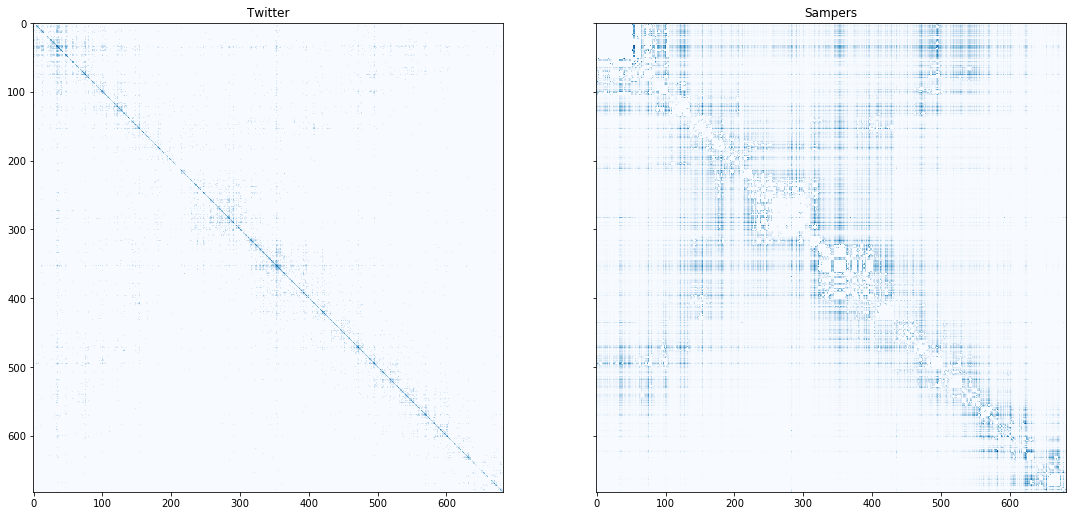

In [423]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(zone_mat_tw, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=odm_twitter.max()['count']), cmap='Blues')
ax2.imshow(zone_mat_samp, norm = mpl.colors.SymLogNorm(1, vmin=0, vmax=np.max(zone_mat_samp)), cmap='Blues')
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()




## The rest is just exploration/pre-study before partition.py was made

In [28]:
latlngodm.reset_index(inplace=True)
latlngodm.set_index('index')

,latitude_o,longitude_o,latitude_d,longitude_d,count
index,,,,,
0,-37.822573,144.969759,-37.818180,144.967874,1
1,-37.765475,144.999465,-37.768194,144.995987,1
2,-34.911528,-57.953708,-34.911027,-57.932324,1
3,-34.911027,-57.932324,-34.911027,-57.932324,1
4,-34.639583,-58.361337,-34.639561,-58.361317,1
...,...,...,...,...,...
51180,68.425577,18.123168,68.348756,18.830859,1
51181,68.426223,18.124317,68.426223,18.124317,2
51182,70.981000,25.972757,70.981000,25.972757,1


In [29]:
shp = sampers.read_shp(sampers.shps['national'])

In [30]:
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
sweden = countries[countries.name == "Sweden"]

In [31]:
lanlngodm_2 = latlngodm.copy()
geo_orig = geopandas.GeoDataFrame(
    latlngodm, 
    crs="EPSG:4326", 
    geometry=geopandas.points_from_xy(latlngodm.longitude_o, latlngodm.latitude_o),
)
geo_dest = geopandas.GeoDataFrame(
    lanlngodm_2, 
    crs="EPSG:4326", 
    geometry=geopandas.points_from_xy(lanlngodm_2.longitude_d, lanlngodm_2.latitude_d),
)

In [32]:
geo_orig.head(n=5)

,index,latitude_o,longitude_o,latitude_d,longitude_d,count,geometry
0,0,-37.822573,144.969759,-37.818180,144.967874,1,POINT (144.96976 -37.82257)
1,1,-37.765475,144.999465,-37.768194,144.995987,1,POINT (144.99946 -37.76548)
2,2,-34.911528,-57.953708,-34.911027,-57.932324,1,POINT (-57.95371 -34.91153)
3,3,-34.911027,-57.932324,-34.911027,-57.932324,1,POINT (-57.93232 -34.91103)
4,4,-34.639583,-58.361337,-34.639561,-58.361317,1,POINT (-58.36134 -34.63958)


In [33]:
geo_dest.head(n=5)

,index,latitude_o,longitude_o,latitude_d,longitude_d,count,geometry
0,0,-37.822573,144.969759,-37.818180,144.967874,1,POINT (144.96787 -37.81818)
1,1,-37.765475,144.999465,-37.768194,144.995987,1,POINT (144.99599 -37.76819)
2,2,-34.911528,-57.953708,-34.911027,-57.932324,1,POINT (-57.93232 -34.91103)
3,3,-34.911027,-57.932324,-34.911027,-57.932324,1,POINT (-57.93232 -34.91103)
4,4,-34.639583,-58.361337,-34.639561,-58.361317,1,POINT (-58.36132 -34.63956)


In [34]:
print(geo_orig.shape)
geo_orig = geopandas.clip(geo_orig, sweden)
print(geo_orig.shape)

(51185, 7)
(43579, 7)


In [35]:
print(geo_dest.shape)
geo_dest = geopandas.clip(geo_dest, sweden)
print(geo_dest.shape)

(51185, 7)
(43529, 7)


In [36]:
geo_orig = geo_orig.to_crs(shp.crs)
geo_dest = geo_dest.to_crs(shp.crs)

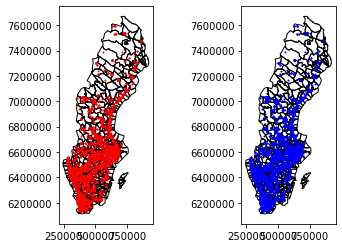

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1_s = shp.plot(ax=ax1, edgecolor='black', facecolor='none', zorder=1)
geo_orig.plot(ax=ax1_s, color='red', markersize=1,zorder=2)
ax2_s = shp.plot(ax=ax2, edgecolor='black', facecolor='none', zorder=1)
geo_orig.plot(ax=ax2_s, color='blue', markersize=1,zorder=2)


In [41]:
geo_orig_zone = geopandas.overlay(geo_orig, shp, how='intersection')
geo_dest_zone = geopandas.overlay(geo_dest, shp, how='intersection')

In [60]:
geo_orig_zone = geo_orig_zone.set_index('index')

In [61]:
geo_dest_zone = geo_dest_zone.set_index('index')

In [62]:
geo_combined = geo_orig_zone.join(geo_dest_zone, on='index', how='inner', rsuffix='_d')

In [66]:
geo_combined

,latitude_o,longitude_o,latitude_d,longitude_d,count,zone,geometry,latitude_o_d,longitude_o_d,latitude_d_d,longitude_d_d,count_d,zone_d,geometry_d
index,,,,,,,,,,,,,,
3471,55.379751,13.106129,55.379555,13.106218,1,982871,POINT (380006.476 6138683.308),55.379751,13.106129,55.379555,13.106218,1,982871,POINT (380011.521 6138661.347)
3505,55.400091,13.022483,55.543312,13.112182,1,982871,POINT (374771.801 6141093.771),55.400091,13.022483,55.543312,13.112182,1,982801,POINT (380884.055 6156871.656)
3548,55.404539,13.048166,55.404858,13.048294,1,982871,POINT (376411.861 6141542.753),55.404539,13.048166,55.404858,13.048294,1,982871,POINT (376420.960 6141578.019)
3549,55.404539,13.048168,55.404488,13.048305,1,982871,POINT (376411.987 6141542.750),55.404539,13.048168,55.404488,13.048305,1,982871,POINT (376420.502 6141536.832)
3670,55.454595,13.188962,55.540409,13.364611,1,982871,POINT (385470.836 6146871.300),55.454595,13.188962,55.540409,13.364611,1,982631,POINT (396802.328 6156144.758)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51177,68.406687,18.675265,66.585735,16.270758,1,995846,POINT (650867.623 7592708.516),68.406687,18.675265,66.585735,16.270758,1,995061,POINT (556346.323 7385773.647)
51178,68.421735,18.107263,68.421735,18.107263,1,995847,POINT (627485.057 7593100.817),68.421735,18.107263,68.421735,18.107263,1,995847,POINT (627485.057 7593100.817)
51179,68.421735,18.107263,68.428979,18.126876,1,995847,POINT (627485.057 7593100.817),68.421735,18.107263,68.428979,18.126876,1,995847,POINT (628248.173 7593948.342)


In [67]:
ODM = geo_combined.groupby(['zone', 'zone_d'], as_index=False).count()[['zone', 'zone_d', 'count']]

,zone,zone_d,count
0,971141,971141,136
1,971141,971151,2
2,971141,971232,3
3,971141,971233,1
4,971141,971262,1
...,...,...,...
3330,995844,995846,1
3331,995846,995061,1
3332,995846,995846,1
3333,995847,995846,1
